In [1]:
%matplotlib inline
%load_ext line_profiler
from __future__ import print_function, division

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, ReflectivityFitFunction, CurveFitter, to_parameters
import refnx.analysis.reflect as reflect

import corner
from lmfit.printfuncs import fit_report
import numpy as np
from matplotlib.pyplot import *

In [2]:
DATASET_NAME = 'c_PLP0011859_q.txt'
USE_DIFFERENTIAL_EVOLUTION = True

#load the data
data = ReflectDataset(DATASET_NAME)

In [3]:
# These arrays described the layered nature of the system.
layers = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   6.36, 0, 3]])     # backing medium

varies = np.array([[False, False, False, False],     # fronting medium
                   [True, False, False, True],     # 1st layer
                   [True, True, False, True],     # 2nd layer
                   [False, False, False, True]])     # backing medium

lowlim = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [15,  3.47, 0, 1],     # 1st layer
                   [200, 0.10, 0, 1],     # 2nd layer
                   [0,   6.36, 0, 1]])     # backing medium

hilim = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 15],     # 2nd layer
                  [0,   6.36, 0, 15]])     # backing medium

In [4]:
# But we need these parameters in a 1D array. convert_layer_format_to_coefs does this.
coefs = reflect.layer_to_coefs(layers, scale=1, bkg=3e-6)
varies = np.asarray(reflect.layer_to_coefs(varies, scale=True, bkg=True), bool)
lowlim = reflect.layer_to_coefs(lowlim, scale=0.6, bkg=0)
hilim = reflect.layer_to_coefs(hilim, scale=1.2, bkg=9e-6)

bounds = zip(lowlim, hilim)

In [5]:
# create a parameter instance
parameters = to_parameters(coefs,
                           names=ReflectivityFitFunction.parameter_names(len(coefs)),
                           bounds=bounds,
                           varies=varies)

In [6]:
# use resolution smearing and fit on a logR scale (transform the data as well)
t = Transform('logY').transform
data.y, data.y_sd = t(data.x, data.y, data.y_sd)
fcn_kws = {'transform': t, 'parallel': True, 'dqvals': data.x_sd}

In [7]:
# create the fit instance
RFF = ReflectivityFitFunction(transform=t)
fitter = CurveFitter(RFF,
                     data,
                     parameters,
                     fcn_kws=fcn_kws)

#do the fit
method = 'leastsq'
if USE_DIFFERENTIAL_EVOLUTION:
    method='differential_evolution'

%time res = fitter.fit(method)

CPU times: user 15.8 s, sys: 386 ms, total: 16.2 s
Wall time: 16.1 s


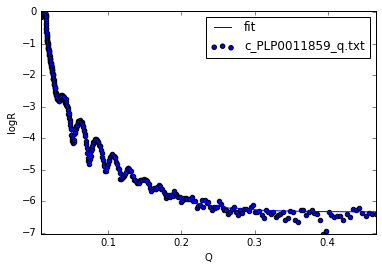

In [8]:
scatter(data.x, data.y, label=DATASET_NAME)
plot(data.x, RFF.model(data.x, res.params, dqvals=data.x_sd), label='fit')
ylim(min(np.min(data.y), np.min(fitter.model(res.params))),
     max(np.max(data.y), np.max(fitter.model(res.params))))
xlim(np.min(data.x), np.max(data.x))
xlabel('Q')
ylabel('logR')
legend()

c_PLP0011859_q.txt
[[Variables]]
    nlayers:      2 (fixed)
    scale:        0.87939473 (init= 1)
    SLDfront:     2.07 (fixed)
    iSLDfront:    0 (fixed)
    SLDback:      6.36 (fixed)
    iSLDback:     0 (fixed)
    bkg:          4.5878e-07 (init= 3e-06)
    sigma_back:   3.78805023 (init= 3)
    thick1:       38.6399298 (init= 30)
    SLD1:         3.47 (fixed)
    iSLD1:        0 (fixed)
    sigma1:       5.84348652 (init= 3)
    thick2:       259.039976 (init= 250)
    SLD2:         2.40201190 (init= 2)
    iSLD2:        0 (fixed)
    sigma2:       8.82392560 (init= 3)
[[Correlations]] (unreported correlations are <  0.100)


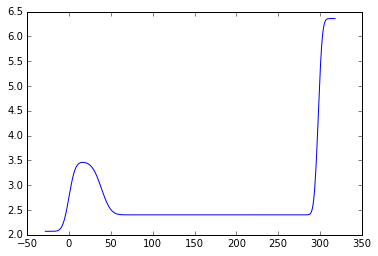

In [9]:
z, rho_z = RFF.sld_profile(res.params)
plot(z, rho_z)

print(DATASET_NAME)
print(fit_report(res.params))

In [10]:
%time res_emcee = fitter.emcee(res.params, steps=1000, burn=400, thin=10, workers=4)

CPU times: user 37.9 s, sys: 736 ms, total: 38.6 s
Wall time: 1min 46s


In [11]:
print(fit_report(res_emcee))

[[Fit Statistics]]
    # function evals   = 0
    # data points      = unknown
    # variables        = 8
    chi-square         = unknown
    reduced chi-square = unknown
[[Variables]]
    nlayers:      2 (fixed)
    scale:        0.87932791 +/- 0.002964 (0.34%) (init= 0.8793947)
    SLDfront:     2.07 (fixed)
    iSLDfront:    0 (fixed)
    SLDback:      6.36 (fixed)
    iSLDback:     0 (fixed)
    bkg:          4.5861e-07 +/- 2.27e-08 (4.95%) (init= 4.587757e-07)
    sigma_back:   3.79046110 +/- 0.115991 (3.06%) (init= 3.78805)
    thick1:       38.6525480 +/- 0.365554 (0.95%) (init= 38.63993)
    SLD1:         3.47 (fixed)
    iSLD1:        0 (fixed)
    sigma1:       5.83165148 +/- 0.294948 (5.06%) (init= 5.843487)
    thick2:       259.032806 +/- 0.251078 (0.10%) (init= 259.04)
    SLD2:         2.40119778 +/- 0.012175 (0.51%) (init= 2.402012)
    iSLD2:        0 (fixed)
    sigma2:       8.81317195 +/- 0.343342 (3.90%) (init= 8.823926)
[[Correlations]] (unreported correlations a

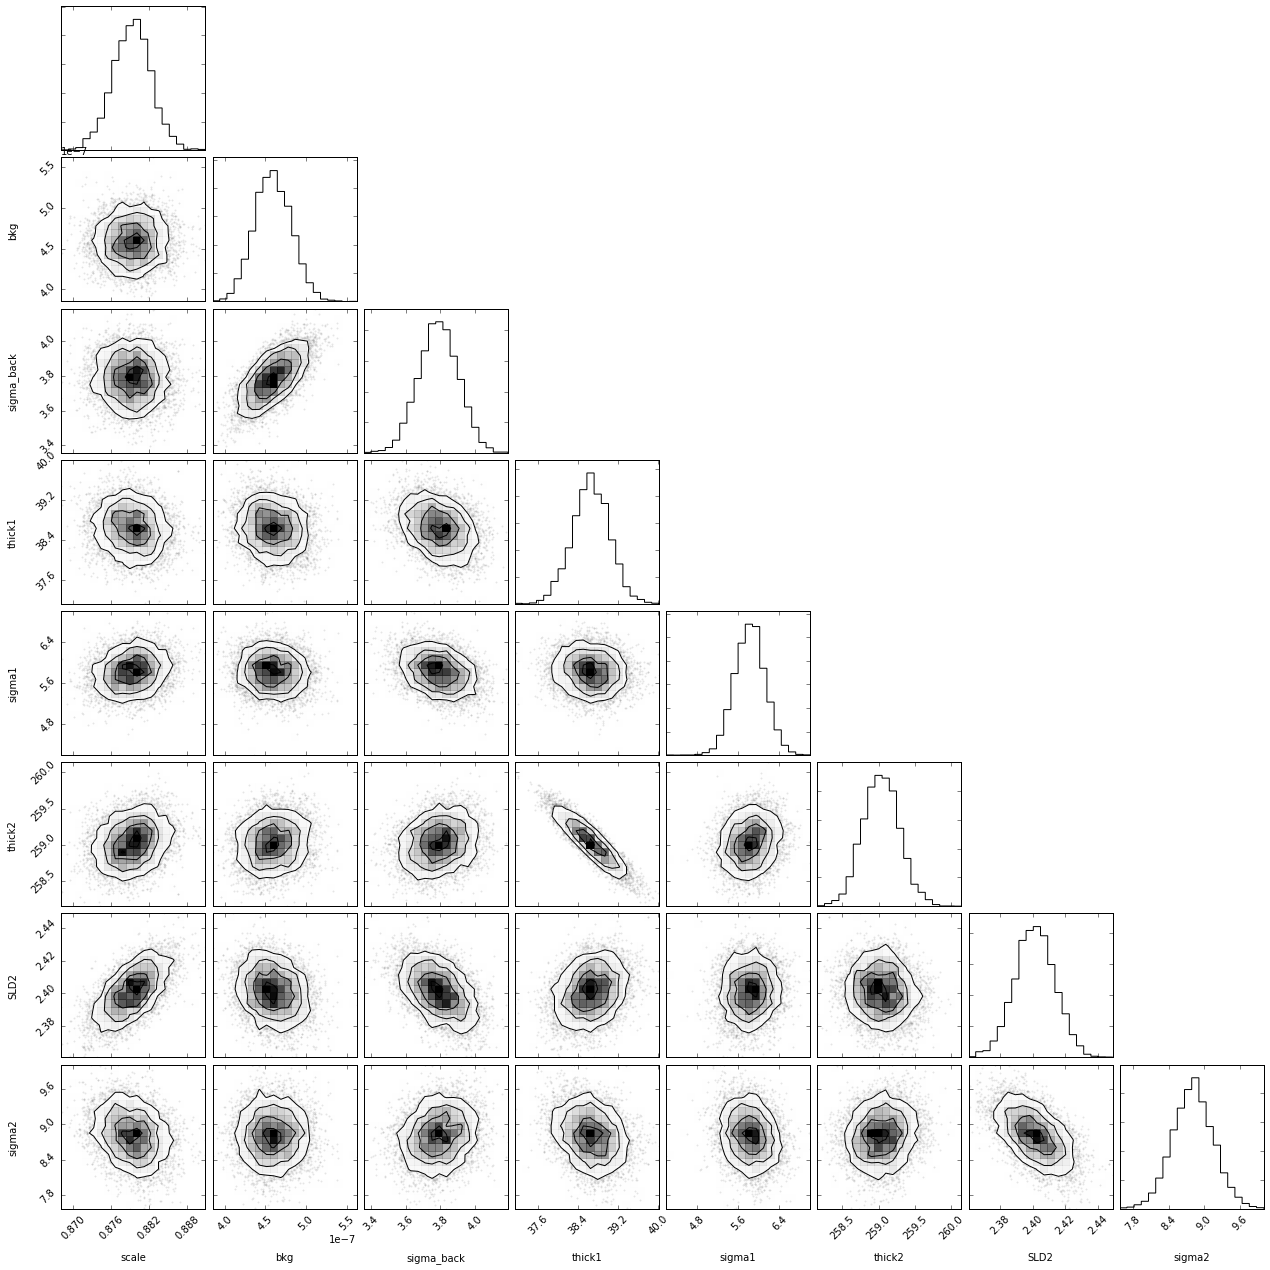

In [12]:
a = corner.corner(res_emcee.flatchain)

In [13]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

(0.0080602199999999999, 0.465555)

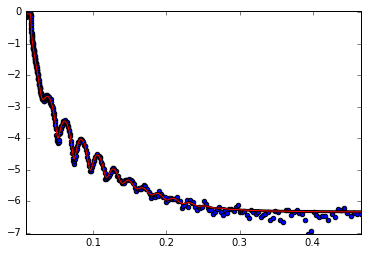

In [14]:
scatter(data.x, data.y)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(data.x, fitter.model(par), color="k", alpha=0.01)
plot(data.x, RFF.model(data.x, res_emcee.params), color='r')

ylim(np.min(data.y), np.max(data.y))
xlim(np.min(data.x), np.max(data.x))

(2.2, 6)

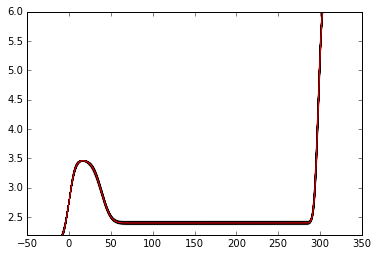

In [15]:
z, true_sld = RFF.sld_profile(res_emcee.params)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(z, RFF.sld_profile(par, points=z)[1], color='k', alpha =0.05)
    
plot(z, true_sld, lw=1, color='r')
ylim(2.2, 6)